In [1]:
# Dependencies
import pandas as pd
import geopandas as gpd
import shapely as sh
import numpy as np
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import os, sys, imp
from pathlib import Path
from fuzzywuzzy import fuzz
from collections import OrderedDict, namedtuple
from joblib import Memory
import warnings
# import streetspace as sp
sp = imp.load_source('sp', '/Users/chesterharvey/Documents/GitHub/StreetSpace/streetspace/__init__.py')
import compare_bikeways
import utm

from bikeways import *

memory = Memory(cachedir='temp', verbose=0)
warnings.filterwarnings('ignore', category=UserWarning)
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## 50 Largest US Cities, 2018
[(World Population Review, 2018)](http://worldpopulationreview.com/us-cities/)


| <p> Rank | <p> Name             | <p> State                | <p> 2018 Population | Bikeway Open Data Source | |
|---------|---------------------|-------------------------|--------------------|--------------------------|-|
| <p> 1    | <p> New York         | <p> New York             | <p> 8,580,015       | <p> [All Bikeways](https://data.cityofnewyork.us/Transportation/Bike-Routes/7vsa-caz7/data) |
| <p> 2    | <p> Los Angeles      | <p> California           | <p> 4,030,668       | <p> [All Bikeways](http://geohub.lacity.org/datasets/1970f85294b748e4bc76415aa9c0b6f0_0) |
| <p> 3    | <p> Chicago          | <p> Illinois             | <p> 2,687,682       | <p> [All Bikeways](https://data.cityofchicago.org/Transportation/Bike-Routes/3w5d-sru8/data) | <p>
| <p> 4    | <p> Houston          | <p> Texas                | <p> 2,340,814       | <p> [All Bikeways](https://cohgis-mycity.opendata.arcgis.com/datasets/houston-bikeways-existing-high-comfort) |
| <p> 5    | <p> Phoenix          | <p> Arizona              | <p> 1,679,243       | <p> No open data source | <p>
| <p> 6    | <p> Philadelphia     | <p> Pennsylvania         | <p> 1,573,688       | <p> [On-Street Bikeways](https://www.opendataphilly.org/dataset/bike-network) <br> [Trails](http://www.pasda.psu.edu/uci/DataSummary.aspx?dataset=1026)| <p>
| <p> 7    | <p> San Antonio      | <p> Texas                | <p> 1,541,456       | <p> No open data source | <p>                               
| <p> 8    | <p> San Diego        | <p> California           | <p> 1,438,060       | <p> [All Bikeways](https://data.sandiego.gov/datasets/bike-route-lines/) | <p>
| <p> 9    | <p> Dallas           | <p> Texas                | <p> 1,359,133       | <p> [On-Street Bikeways](https://www.dallasopendata.com/Geography-Boundaries/On-Street-Bike-Routes/ax7n-9dfm) <br> [Trails](https://www.dallasopendata.com/Geography-Boundaries/Bike-Trails/jewx-caad) | <p> 
| <p> 10   | <p> San Jose         | <p> California           | <p> 1,030,796       | <p> [All Bikeways](https://gisdata-csjdotgis.opendata.arcgis.com/datasets/c11135e9728d402f81c255199095f3e9_2) | <p>
| <p> 11   | <p> Austin           | <p> Texas                | <p> 983,366         | <p> [On-Street Bikeways](http://services.arcgis.com/0L95CJ0VTaxqcmED/arcgis/rest/services/TRANSPORTATION_bicycle_facilities/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=geojson) <br> [Trails](https://data.austintexas.gov/Locations-and-Maps/Urban-Trails/bxbe-ndaw) | <p>
| <p> 12   | <p> Jacksonville     | <p> Florida              | <p> 907,529         | <p> No open data source | <p>
| <p> 13   | <p> Fort Worth       | <p> Texas                | <p> 893,997         | <p> [All Bikeways](https://mapitwest.fortworthtexas.gov/Html5Viewer/?viewer=fwgisdata) | <p>
| <p> 14   | <p> San Francisco    | <p> California           | <p> 888,653         | <p> [All Bikeways](https://data.sfgov.org/Transportation/SFMTA-Bikeway-Network/aupf-nbjc) | <p>
| <p> 15   | <p> Columbus         | <p> Ohio                 | <p> 880,182         | <p> [All Bikeways](https://data-columbus.opendata.arcgis.com/datasets/183ca6a5e04e4dfc840b0c626ce4a5f5_0?geometry=-89.906%2C38.452%2C-77.788%2C41.4) | <p>
| <p> 16   | <p> Charlotte        | <p> North Carolina       | <p> 873,363         | <p> [Bike Lanes](http://maps.co.mecklenburg.nc.us/opendata/BikeLanes.zip) <br> [Bike Routes](http://maps.co.mecklenburg.nc.us/opendata/BikeRoutes_Signed.zip) | <p>
| <p> 17   | <p> Indianapolis     | <p> Indiana              | <p> 860,902         | <p> [Bike Lanes](https://data1-indygis.opendata.arcgis.com/datasets/bike-lanes) <br> [Trails](https://data1-indygis.opendata.arcgis.com/datasets/1449faf233704544bdadeedc4d284d32_9) | <p>
| <p> 18   | <p> Seattle          | <p> Washington           | <p> 746,046         | <p> [All Bikeways](https://data-seattlecitygis.opendata.arcgis.com/datasets/existing-bike-facilities) | <p>
| <p> 19   | <p> Denver           | <p> Colorado             | <p> 719,116         | <p> [All Bikeways](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-denver-bicycle-facilities) |
| <p> 20   | <p> Washington       | <p> District of Columbia | <p> 702,756         | <p> [On-Street Bikeways](http://opendata.dc.gov/datasets/bicycle-lanes) <br> [Trails](http://opendata.dc.gov/datasets/bike-trails) | <p>
| <p> 21   | <p> El Paso          | <p> Texas                | <p> 692,100         | <p> No open data source | <p>
| <p> 22   | <p> Boston           | <p> Massachusetts        | <p> 687,584         | <p> [All Bikeways](https://data.boston.gov/dataset/existing-bike-network) | <p>
| <p> 23   | <p> Nashville        | <p> Tennessee            | <p> 673,008         | <p> No open data source | <p>
| <p> 24   | <p> Detroit          | <p> Michigan             | <p> 665,713         | <p> [On-Street Bikeways](http://portal.datadrivendetroit.org/datasets/4b886654a8d846a782658bd4712e7952_0?geometry=-83.536%2C42.302%2C-82.641%2C42.454) <br> [Trails](https://data.detroitmi.gov/Transportation/Greenways/fy5z-ths7) | <p>
| <p> 25   | <p> Portland         | <p> Oregon               | <p> 658,347         | <p> [All Bikeways](http://rlisdiscovery.oregonmetro.gov/?action=viewDetail&layerID=3312) | <p>
| <p> 26   | <p> Oklahoma City    | <p> Oklahoma             | <p> 653,865         | <p> [Trails](https://data.okc.gov/portal/page/viewer?datasetName=Trails&view=map) | <p>
| <p> 27   | <p> Las Vegas        | <p> Nevada               | <p> 653,840         | <p> [All Bikeways](https://geocommons-lasvegas.opendata.arcgis.com/datasets/existing-bike-lanes-and-multi-use-trails) | <p>
| <p> 28   | <p> Memphis          | <p> Tennessee            | <p> 649,243         | <p> No open data source | <p>
| <p> 29   | <p> Louisville       | <p> Kentucky             | <p> 619,287         | <p> [All Bikeways](https://data.louisvilleky.gov/dataset/bike-route-data) | <p>
| <p> 30   | <p> Baltimore        | <p> Maryland             | <p> 601,188         | <p> [On-Street Bikeways](https://data.baltimorecity.gov/Transportation/On-Street-Bike-Facilities/2fxj-ph4e) <br> [Trails](https://data.baltimorecity.gov/Transportation/Multi-Use-Trails/ca8m-ir6r) | <p>
| <p> 31   | <p> Milwaukee        | <p> Wisconsin            | <p> 586,315         | <p> No open data source |
| <p> 32   | <p> Albuquerque      | <p> New Mexico           | <p> 562,935         | <p> [All Bikeways](http://coagisweb.cabq.gov/datadownload/biketrails.zip) |
| <p> 33   | <p> Tucson           | <p> Arizona              | <p> 535,236         | <p> No open data source |
| <p> 34   | <p> Fresno           | <p> California           | <p> 529,153         | <p> No open data source |
| <p> 35   | <p> Sacramento       | <p> California           | <p> 507,298         | <p> No open data source |
| <p> 36   | <p> Mesa             | <p> Arizona              | <p> 497,275         | <p> [On-Street Bikeways](http://opengis.mesaaz.gov/datasets/186b5588c0b8496584d54f0dd9c2d147_0) <br> [Trails](http://opengis.mesaaz.gov/datasets/ef0c79478b2245c1b741ccaebcce3764_0) |
| <p> 37   | <p> Kansas City      | <p> Missouri             | <p> 494,536         | <p> No open data source |
| <p> 38   | <p> Atlanta          | <p> Georgia              | <p> 491,626         | <p> [All Bikeways](http://opendata.atlantaregional.com/datasets/metro-atlanta-bicycle-facility-inventory-2014/data)
| <p> 39   | <p> Colorado Springs | <p> Colorado             | <p> 484,233         | <p> No open data source |
| <p> 40   | <p> Miami            | <p> Florida              | <p> 479,009         | <p> [Bike Lane](https://gis-mdc.opendata.arcgis.com/datasets/bike-lane) <br> [Trail](https://gis-mdc.opendata.arcgis.com/datasets/dbc4523578c74ea09b6265c94b831d26_1) <br> [Wide Curb](https://gis-https://gis-mdc.opendata.arcgis.com/datasets/wide-curb-lane) <br> [Paved Shoulder](https://gis-mdc.opendata.arcgis.com/datasets/paved-shoulder) |
| <p> 41   | <p> Raleigh          | <p> North Carolina       | <p> 476,746         | <p> No open data source |
| <p> 42   | <p> Long Beach       | <p> California           | <p> 467,512         | <p> [All Bikeways](http://www.longbeach.gov/ti/media-library/documents/gis/data-catalog/bikeways/) |
| <p> 43   | <p> Virginia Beach   | <p> Virginia             | <p> 454,098         | <p> [All Bikeways](http://gis-vbgov.opendata.arcgis.com/datasets/6a3fe5dc1aee44a98919b4e766f3ac64_1) |
| <p> 44   | <p> Omaha            | <p> Nebraska             | <p> 450,364         | <p> [Trails](https://data-dogis.opendata.arcgis.com/datasets/trails)
| <p> 45   | <p> Oakland          | <p> California           | <p> 424,275         | <p> [All Bikeways](https://data.acgov.org/Transportation/Alameda-County-Bikeways/nmph-ksak) |
| <p> 46   | <p> Minneapolis      | <p> Minnesota            | <p> 420,721         | <p> [All Bikeways](https://gis-hennepin.opendata.arcgis.com/datasets/938c8598f0a0439a8d612bb7894a05cc_1) |
| <p> 47   | <p> Tulsa            | <p> Oklahoma             | <p> 403,060         | <p> No open data source |
| <p> 48   | <p> Arlington        | <p> Texas                | <p> 401,248         | <p> [On-Street Bikeways](http://data-arlingtontx.opendata.arcgis.com/datasets/on-street-hike-and-bike) <br> [Off-Street Bikeways](http://data-arlingtontx.opendata.arcgis.com/datasets/61072b3fb8d14520a5ec50185dcf82a2_3) |
| <p> 49   | <p> New Orleans      | <p> Louisiana            | <p> 395,009         | <p> [Bike Lanes](https://data.nola.gov/dataset/Bike-Lanes/8npz-j6vy) |
| <p> 50   | <p> Tampa            | <p> Florida              | <p> 394,507         | <p> [Bike Lanes](http://gis2017-01-10t133755357z-hillsborough.opendata.arcgis.com/datasets/bike-lanes?geometry=-83.423%2C27.72%2C-81.445%2C28.145) <br> [Trails](http://gis2017-01-10t133755357z-hillsborough.opendata.arcgis.com/datasets/existing-greenway-recreation-corridors) |

In [2]:
# # Template classification function

# test = gpd.read_file('XXXXX')

# def classify_XXXX_bikeways(row):
#     if row['XXXX'] == 'XXXX':
#         return 'off_street_path'
#     elif row['XXXX'] == 'XXXX':
#         return 'bike_blvd'
#     elif row['XXXX'] == 'XXXX':
#         return 'separated_bike_lane'
#     elif row['XXXX'] == 'XXXX':
#         return 'bike_lane'
#     elif row['XXXX'] == 'XXXX':
#         return 'shoulder'
#     elif row['XXXX'] == 'XXXX':
#         return 'sharrow'
#     elif row['XXXX'] == 'XXXX':
#         return 'bike_route'
#     else:
#         return np.nan

In [3]:
# Initialize list to store results for each city
cities = []

## New York

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Off Street Path'
Double Matching 'Exclusive'
Double Matching 'Shared'
Double Matching 'Any'


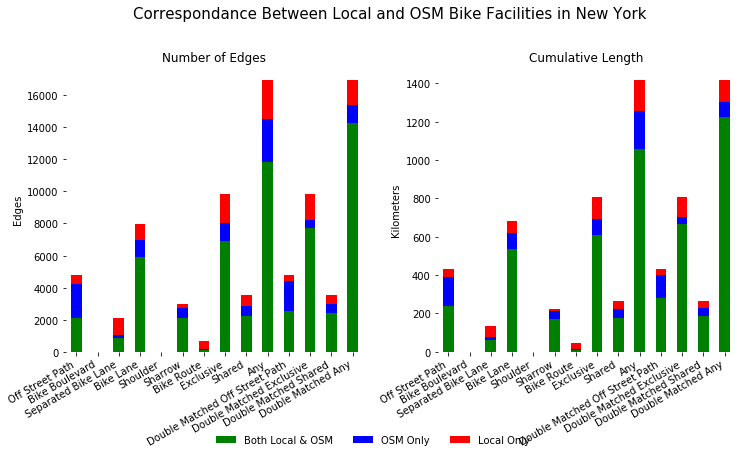

In [4]:
try:
    def classify_nyc_bikeways(row):
        def any_bikeway(bikeway):
            bikeway_fields = [row['ft_facilit'], row['tf_facilit']]
            return any([bikeway in x if x is not None else False 
                        for x in bikeway_fields])   
        if(
            any_bikeway('Greenway') or
            any_bikeway('Boardwalk') or
            any_bikeway('Ped Plaza') or
            any_bikeway('Dirt Trail')):
            return 'off_street_path'
        elif(
            any_bikeway('Buffered Conventional') or
            any_bikeway('Protected Path')):
            return 'separated_bike_lane'
        elif( 
            any_bikeway('Bike-Friendly Parking') or
            any_bikeway('Curbside') or
            any_bikeway('Standard')):
            return 'bike_lane'
        elif(
            any_bikeway('Sharrow')):
            return 'sharrow'
        elif(
            any_bikeway('Signed Route')):
            return 'bike_route'
        else:
            return np.nan

    new_york = City(
        name='New York',
        boundary_query='New York City, New York, USA',
        boundary_number=0,
        local_bikeways={
            'file': 'bikeway_shapefiles/New York/NewYorkBikeways.shp',
            'classification_function': classify_nyc_bikeways,
            'name_column': 'street'},
        verbose=True)

    cities.append(new_york)
    new_york.plot_matches()
except:
    print('failed')

In [6]:
new_york.summarize_lengths()

osm bikeway length: 1302 km
local bikeway length: 1236 km
local matched bikeway length: 1220 km
local & OSM bikeway length: 1058 km
dbl local & OSM bikeway length: 1223 km
local only bikeway length: 162 km
dbl local only bikeway length: 113 km
osm only bikeway length: 195 km
dbl osm only bikeway length: 79 km


In [ ]:
# sp.plot_shapes([(city.local_bikeways, {'color':'k'}), 
#                 (city.matched_bikeways[(city.matched_bikeways['any_bikeway_local'] == 1) & 
#                                        (city.matched_bikeways['any_bikeway_osm'] == 0)], {'color':'r'})], leaflet=True)

## Los Angeles

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Off Street Path'
Double Matching 'Exclusive'
Double Matching 'Shared'
Double Matching 'Any'


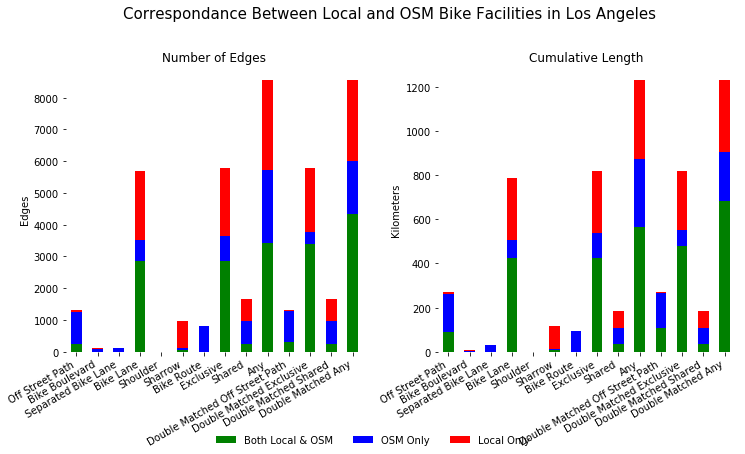

In [7]:
try:
    # Los Angeles
    def classify_la_bikeways(row):
        if row['Class'] == 1:
            return 'off_street_path'
        elif row['Class'] == 0:
            return 'bike_blvd'
        elif row['Class'] == 2:
            return 'bike_lane'
        elif row['Bikeway'] == 'Sharrowed Route':
            return 'sharrow'
        elif row['Bikeway'] == 'Route':
            return 'route'
        else:
            return np.nan

    los_angeles = City(
        name='Los Angeles',
        boundary_query='Los Angeles, Los Angeles County, California, USA',
        local_bikeways={
            'file': 'bikeway_shapefiles/Los Angeles/LosAngelesBikeways.shp',
            'classification_function': classify_la_bikeways,
            'name_column': 'ST_NAME'},
        verbose=True)

    cities.append(los_angeles)
    los_angeles.plot_matches()
except:
    print('failed')

## Chicago

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Off Street Path'
Double Matching 'Exclusive'
Double Matching 'Shared'
Double Matching 'Any'


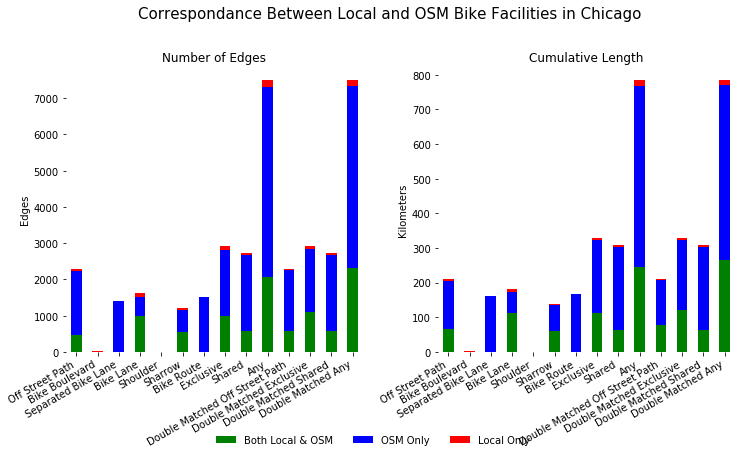

In [8]:
try:
    # Chicago
    def classify_chicago_bikeways(row):
        if row['bikeroute'] in ['OFF-STREET TRAIL','ACCESS PATH']:
            return 'off_street_path'
        elif row['bikeroute'] == 'NEIGHBORHOOD GREENWAY':
            return 'bike_blvd'
        elif row['bikeroute'] == 'BIKE LANE':
            return 'bike_lane'
        elif row['bikeroute'] in ['BUFFERED BIKE LANE, CYCLE TRACK']:
            return 'separated_bike_lane'
        elif row['bikeroute'] in ['BUFFERED BIKE LANE, CYCLE TRACK']:
            return 'separated_bike_lane'
        elif row['bikeroute'] == 'SHARED-LANE':
            return 'sharrow'
        else:
            return np.nan

    chicago = City(
        name='Chicago',
        boundary_query='Chicago, Cook County, Illinois, USA',
        local_bikeways={
            'file': 'bikeway_shapefiles/Chicago/ChicagoBikeways.shp',
            'classification_function': classify_chicago_bikeways,
            'name_column': 'street'},
        verbose=True)

    cities.append(chicago)
    chicago.plot_matches()
except:
    print("didn't work")

## Houston

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Off Street Path'
Double Matching 'Exclusive'
Double Matching 'Shared'
Double Matching 'Any'


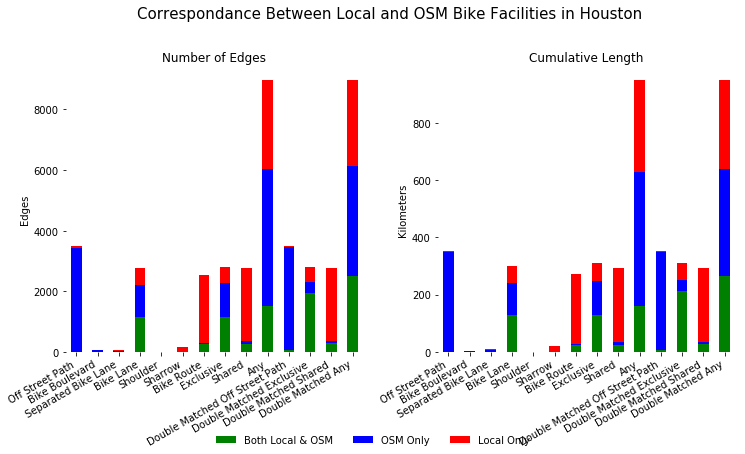

In [9]:
try:
    # Houston
    def classify_houston_bikeways(row):
        if row['B_Type_Exi'] == 'Shared-Use Path':
            return 'off_street_path'
        elif row['B_Type_Exi'] == 'Cycle Track':
            return 'separated_bike_lane'
        elif row['B_Type_Exi'] == 'Bike Lane':
            return 'bike_lane'
        elif row['B_Type_Exi'] == 'Signed Shared Roadway':
            return 'sharrow'
        elif row['B_Type_Exi'] == 'Signed Bike Route':
            return 'bike_route'
        else:
            return np.nan

    houston = City(
        name='Houston',
        boundary_query='Houston, Harris County, Texas, USA',
        boundary_number=0,
        local_bikeways={
            'file': 'bikeway_shapefiles/Houston/HoustonBikeways.shp',
            'classification_function': classify_houston_bikeways,
            'name_column': 'FULL_NAME'},
        verbose=True
    )

    cities.append(houston)
    houston.plot_matches()
except:
    print("didn't work")

## Phoenix

Matching Local and OSM Bikeways


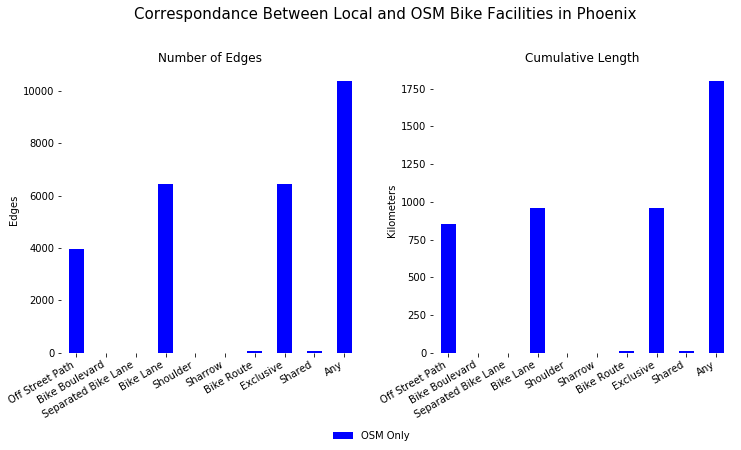

In [10]:
try:
    # Phoenix
    # No open data source
    phoenix = City(
        name='Phoenix',
        boundary_query='Phoenix, Maricopa County, Arizona, USA',
        verbose=True
    )

    cities.append(phoenix)
    phoenix.plot_matches()
except:
    print("didn't work")

## Philadelphia

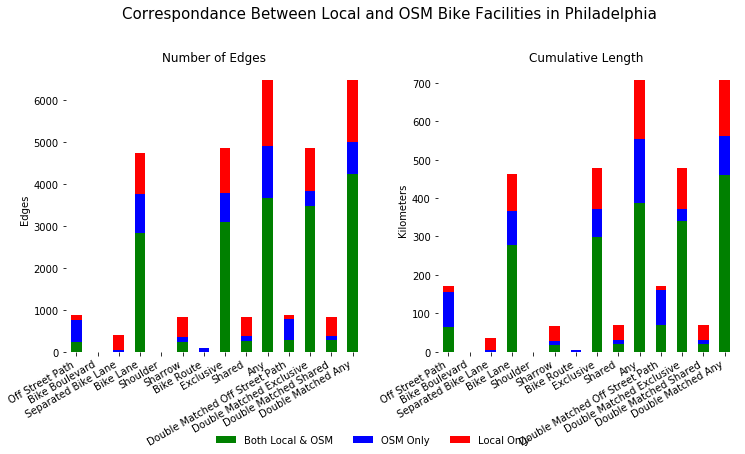

In [11]:
try:
    # Philadelphia
    def classify_philadelphia_on_street(row):
        if row['TYPE'] in [
            'Paint Buffered',
            'Paint Buffered w Conventional', 
            'Contraflow w Conventional, same',
            'Two Way Protected Bicycle Lane',
            'One Way Protected Bicycle Lane']:
            return 'separated_bike_lane'
        elif row['TYPE'] in ['Conventional', 'Conventional w Sharrows']:
            return 'bike_lane'
        elif row['TYPE'] in ['Sharrow', 'Bus Bike Lane']:
            return 'sharrow'
        else:
            return np.nan

    def classify_philadelphia_trail(row):
        # All records are trails
        return 'off_street_path'

    philadelphia = City(
        name='Philadelphia',
        boundary_query='Philadelphia, Philadelphia County, Pennsylvania, USA',
        local_bikeways=[
            {'file': 'bikeway_shapefiles/Philadelphia/PhiladelphiaBikeways.shp',
            'classification_function': classify_philadelphia_on_street,
            'name_column': 'STREETNAME'},
            {'file': 'bikeway_shapefiles/Philadelphia/PhiladelphiaTrails.shp',
            'classification_function': classify_philadelphia_trail,
            'name_column': 'NAME'}],
    #     verbose=True
    )

    cities.append(philadelphia)
    philadelphia.plot_matches()
except:
    print("didn't work")

## San Antonio

Matching Local and OSM Bikeways


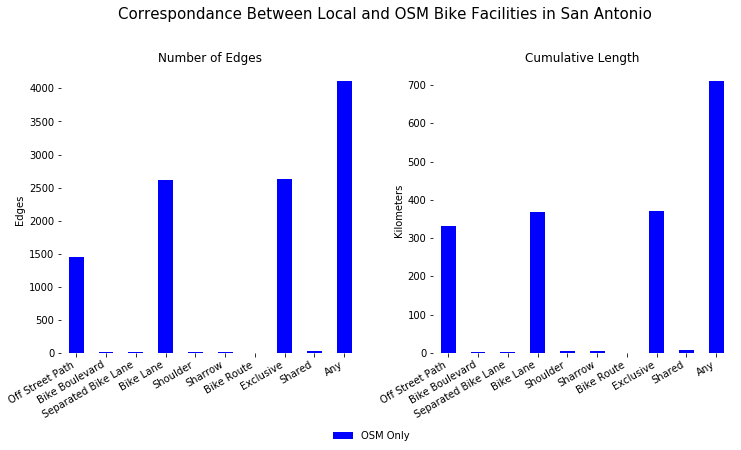

In [12]:
try:
    # San Antonio
    # No open data source
    san_antonio = City(
        name='San Antonio',
        boundary_query='San Antonio, Bexar County, Texas, USA',
        boundary_number=0,
        verbose=True
    )

    cities.append(san_antonio)
    san_antonio.plot_matches()
except:
    print("didn't work")

## San Diego

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Off Street Path'
Double Matching 'Exclusive'
Double Matching 'Shared'
Double Matching 'Any'


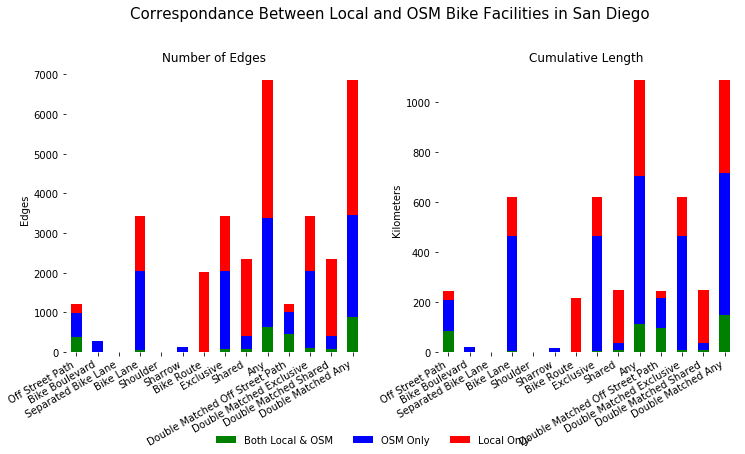

In [13]:
try:
    # San Diego
    def classify_san_diego_bikeways(row):
        if row['class'] == 'Multi-Use Path':
            return 'off_street_path'
        elif row['class'] == 'Bike Lane':
            return 'bike_lane'
        elif row['class'] == 'Bike Route':
            return 'bike_route'
        else:
            return np.nan

    san_diego = City(
        name='San Diego',
        boundary_query='San Diego, San Diego County, California, USA',
        local_bikeways={
            'file': 'bikeway_shapefiles/San Diego/SanDiegoBikeways.shp',
            'classification_function': classify_san_diego_bikeways,
            'name_column': 'rd20full'},
        verbose=True)

    cities.append(san_diego)
    san_diego.plot_matches()
except:
    print("didn't work")

## Dallas

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Off Street Path'


Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x1489469b0>>
Traceback (most recent call last):
  File "/Users/chesterharvey/miniconda2/envs/mti/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/Users/chesterharvey/miniconda2/envs/mti/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'


Double Matching 'Exclusive'
Double Matching 'Any'


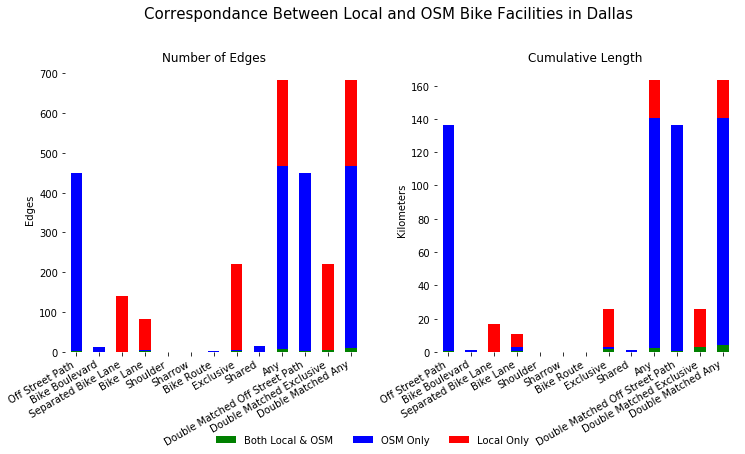

In [14]:
try:
    # Dallas
    def classify_dallas_bikeways(row):
        if row['fac_type'] == 'OffStreet':
            return 'off_street_path'
        elif row['fac_type'] in ['Buffered Bike Lane', 'Cycle Track', 'Buf BL/CT']:
            return 'separated_bike_lane'
        elif row['fac_type'] in ['Bike Lanes', 'Bike Lane']:
            return 'bike_lane'
        elif row['fac_type'] == ['Sharrow', 'Sharrows']:
            return 'sharrow'
        else:
            return np.nan

    # Bikeways are provided in four seperate shapefiles with similar columns
    dallas_bikeways = pd.concat([
        gpd.read_file('bikeway_shapefiles/Dallas/DallasBikeways_1.shp'),
        gpd.read_file('bikeway_shapefiles/Dallas/DallasBikeways_2.shp'),
        gpd.read_file('bikeway_shapefiles/Dallas/DallasBikeways_3.shp'),
        gpd.read_file('bikeway_shapefiles/Dallas/DallasBikeways_4.shp')],
        ignore_index=True)

    dallas = City(
        name='Dallas',
        boundary_query='Dallas, Dallas County, Texas, USA',
        boundary_number=0,
        local_bikeways={
            'file': dallas_bikeways,
            'classification_function': classify_dallas_bikeways,
            'name_column': 'location'},
        verbose=True
    )

    cities.append(dallas)
    dallas.plot_matches()
except:
    print("didn't work")

## San Jose

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Off Street Path'
Double Matching 'Exclusive'
Double Matching 'Shared'
Double Matching 'Any'


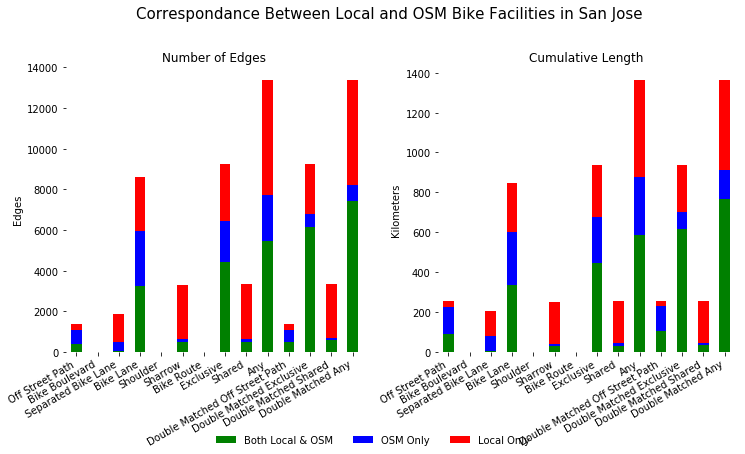

In [15]:
try:
    # San Jose
    def classify_san_jose_bikeways(row):
        if (row['BikeClass'] == 'Class 1 (Bike Trails)' or
            row['Type_1'] == 'No Cars'):
            return 'off_street_path'
        elif row['Type_1'] == 'Protected Lane':
            return 'separated_bike_lane'
        elif (row['BikeClass'] == 'Class 2 (Bike Lanes)' or
              row['Type_1'] == 'Bike Lane'):
            return 'bike_lane'
        elif (row['BikeClass'] == 'Class 3 (Bike Routes)' or
              row['Type_1'] == 'Sharrows'):
            return 'sharrow'
        else:
            return np.nan

    san_jose = City(
        name='San Jose',
        boundary_query='San José, Santa Clara County, California, USA',
        local_bikeways={
            'file': 'bikeway_shapefiles/San Jose/SanJoseBikeways.shp',
            'classification_function': classify_san_jose_bikeways,
            'name_column': 'NAME'},
        verbose=True
    )

    cities.append(san_jose)
    san_jose.plot_matches()
except:
    print("didn't work")

## Austin

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Off Street Path'
Double Matching 'Exclusive'
Double Matching 'Shared'
Double Matching 'Any'


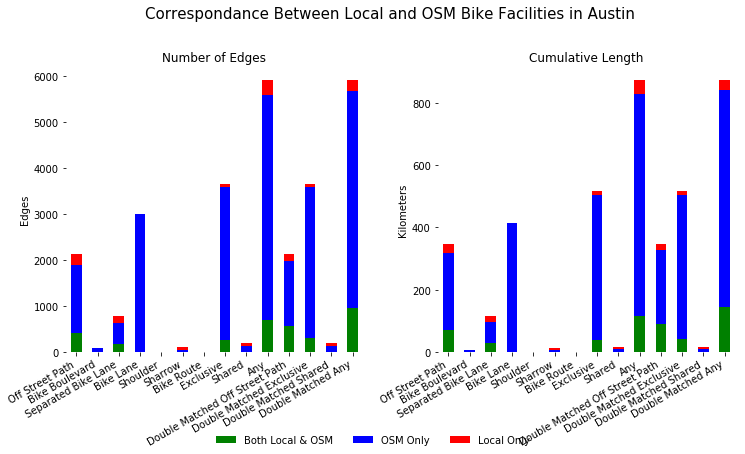

In [84]:
try:
    # Austin
    def classify_austin_bikeways(row):
        if row['EXISTING_FACILITY'] == 'MUPATH':
            return 'off_street_path'
        elif row['EXISTING_FACILITY'] in ['BUFFRDBIKELN', 'CYCLETRK']:
            return 'separated_bike_lane'
        elif row['EXISTING_FACILITY'] == ['BIKELN', 'BIKELNPK','CLIMBLN']:
            return 'bike_lane'
#         elif row['EXISTING_FACILITY'] in ['WIDECURB', 'WIDESHLD']:
#             return 'shoulder'
# #         elif row['EXISTING_FACILITY'] in ['SHAREDLN','SHARROWS']:
        elif row['EXISTING_FACILITY'] in ['SHARROWS']:
            return 'sharrow'
        else:
            return np.nan

    def classify_austin_trails(row):
        if row['build_stat'] == 'EXISTING':
            return 'off_street_path'
        else:
            return np.nan

    austin = City(
        name='Austin',
        boundary_query='Austin, Travis County, Texas, USA',
        boundary_number=0,
        local_bikeways=[
            {'file': 'bikeway_shapefiles/Austin/AustinBikeways.geojson',
            'classification_function': classify_austin_bikeways,
            'name_column': 'ROUTE_NAME'},
            {'file': 'bikeway_shapefiles/Austin/AustinTrails.shp',
            'classification_function': classify_austin_trails,
            'name_column': 'urban_tr_4'}],
        verbose=True
    )

    cities.append(austin)
    austin.plot_matches()
except:
    print("didn't work")

In [85]:
austin.plot_comparison('any_bikeway', leaflet=True, plot_raw_local=True, save_shapefiles=False)

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14e0ea048>)

## Jacksonville

Matching Local and OSM Bikeways


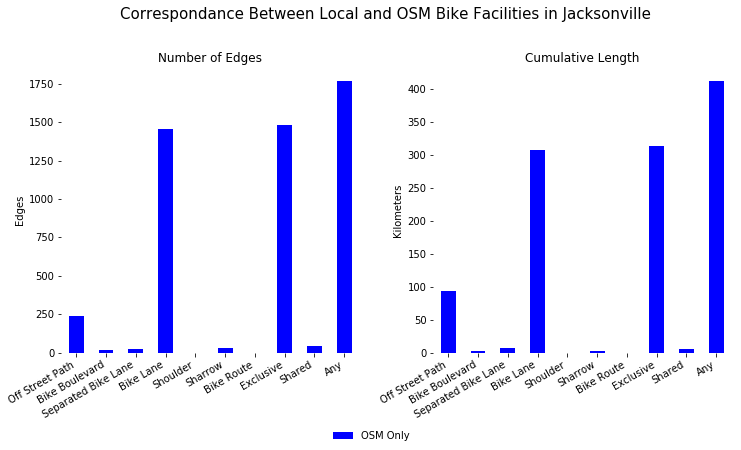

In [18]:
try:
    # Jacksonville
    # No open data source
    jacksonville = City(
        name='Jacksonville',
        boundary_query='Jacksonville, Duval County, Florida, USA',
        verbose=True
    )

    cities.append(jacksonville)
    jacksonville.plot_matches()
except:
    print("didn't work")

## Fort Worth

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Off Street Path'
Double Matching 'Exclusive'
Double Matching 'Shared'
Double Matching 'Any'


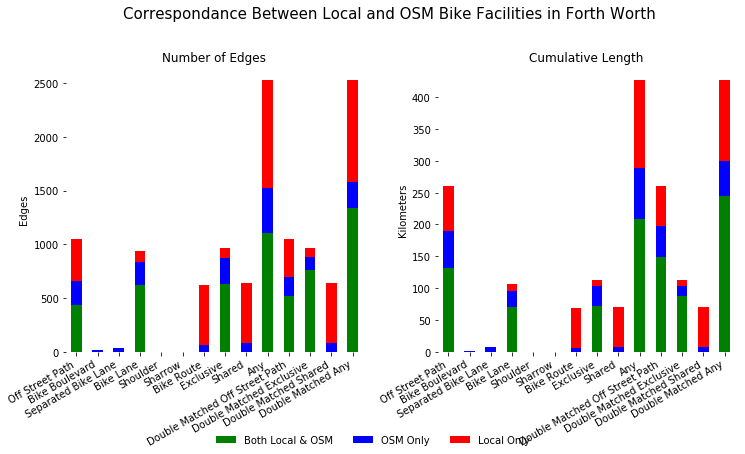

In [19]:
try:
    # Forth Worth
    def classify_fort_worth_bikeways(row):
        if row['FACILITY'] in ['Existing Paved Trail',
                               'Regional Veloweb',
                               'Existing Natural Surface Trail',
                               'Existing Sidepath']:
            return 'off_street_path'
        elif row['FACILITY'] == 'Existing On-Street Bike Lane':
            return 'bike_lane'
        elif row['FACILITY'] == 'Existing On-Street Signed Route':
            return 'bike_route'
        else:
            return np.nan

    forth_worth = City(
        name='Forth Worth',
        boundary_query='Fort Worth, Tarrant County, Texas, USA',
        boundary_number=0,
        local_bikeways={
            'file': 'bikeway_shapefiles/Fort Worth/FortWorthBikeways.shp',
            'classification_function': classify_fort_worth_bikeways,
            'name_column': 'STREET_NAM'},
        verbose=True
    )

    cities.append(forth_worth)
    forth_worth.plot_matches()
except:
    print("didn't work")

## San Francisco

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Off Street Path'
Double Matching 'Exclusive'
Double Matching 'Shared'
Double Matching 'Any'


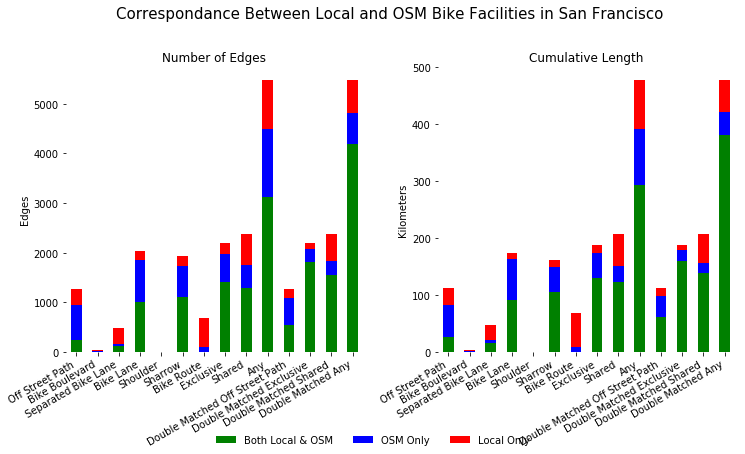

In [20]:
try:
    # San Francisco
    def classify_sf_bikeways(row):
        if row['facility_t'] == 'CLASS I':
            return 'off_street_path'
        elif row['symbology'] == 'NEIGHBORWAY':
            return 'bike_blvd'
        elif ((row['facility_t'] == 'CLASS IV') or 
              (row['buffered'] == 'YES') or
              (pd.notnull(row['barrier'])) or
              (row['raised'] == 'YES')):
            return 'separated_bike_lane'
        elif row['facility_t'] == 'CLASS II':
            return 'bike_lane'
        elif row['sharrow'] > 0:
            return 'sharrow'
        elif row['symbology'] == 'BIKE ROUTE':
            return 'bike_route'
        else:
            return np.nan

    san_francisco = City(
        name='San Francisco',
        boundary_query='San Francisco City and County, California, USA',
        boundary_number=1,
        local_bikeways={
            'file': 'bikeway_shapefiles/San Francisco/SanFranciscoBikeways.shp',
            'classification_function': classify_sf_bikeways,
            'name_column': 'street'},
        verbose=True
    )

    cities.append(san_francisco)
    san_francisco.plot_matches()
except:
    print("didn't work")

## Columbus

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Off Street Path'
Double Matching 'Exclusive'
Double Matching 'Shared'
Double Matching 'Any'


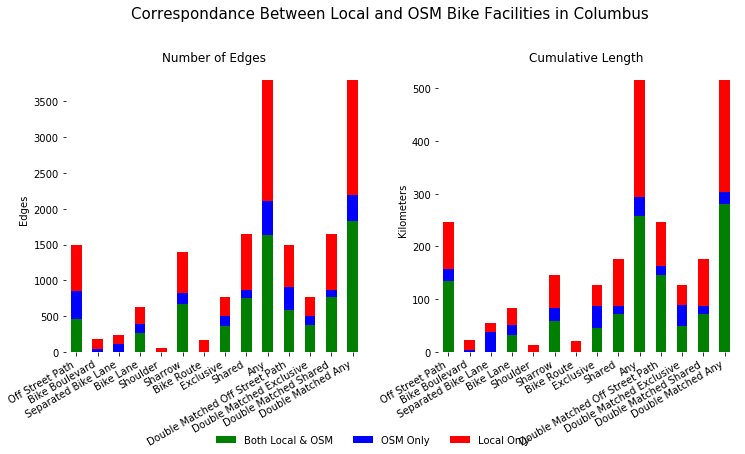

In [21]:
try:
    # Columbus
    def classify_columbus_bikeways(row):
        if (row['FACILITYST'] == 'EX' and # Existing
            row['FACILITYTY'] == 'PATH'):
            return 'off_street_path'
        elif (row['FACILITYST'] == 'EX' and
              row['FACILITYTY'] == 'BB'): # Bike Boulevard
            return 'bike_blvd'
        elif (row['FACILITYST'] == 'EX' and
              row['FACILITYTY'] == 'PBL'): # Protected Bike Lane
            return 'separated_bike_lane'
        elif (row['FACILITYST'] == 'EX' and
              row['FACILITYTY'] == 'LANE' and # Bike Lane
              row['BUFFERZONE'] in [
                  'BTS', # Buffered Travel Side
                  'BBS']): # Buffered Both Sides
            return 'separated_bike_lane'
        elif (row['FACILITYST'] == 'EX' and
              row['FACILITYTY'] == 'LANE'): # Bike Lane
            return 'bike_lane'
        elif (row['FACILITYST'] == 'EX' and
              row['FACILITYTY'] == 'PS'): # Paved Shoulder
            return 'shoulder'
        elif (row['FACILITYST'] == 'EX' and
              row['FACILITYTY'] == 'SH'): # Sharrow
            return 'sharrow'
        elif (row['FACILITYST'] == 'EX' and
              row['FACILITYTY'] == 'RT'): # Route
            return 'bike_route'
        else:
            return np.nan

    columbus = City(
        name='Columbus',
        boundary_query='Columbus, Franklin County, Ohio, USA',
        boundary_number=0,
        local_bikeways={
            'file': 'bikeway_shapefiles/Columbus/ColumbusBikeways.shp',
            'classification_function': classify_columbus_bikeways,
            'name_column': 'STREETNAME'},
        verbose=True
    )

    cities.append(columbus)
    columbus.plot_matches()
except:
    print("didn't work")

## Charlotte

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Exclusive'
Double Matching 'Shared'
Double Matching 'Any'


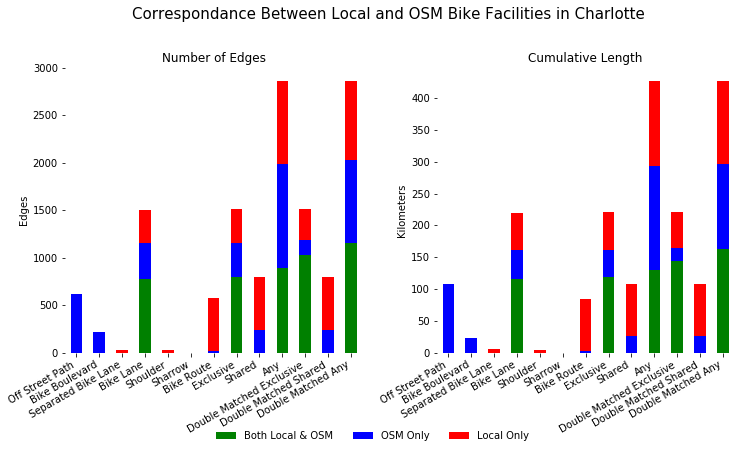

In [22]:
try:
    # Charlotte
    def classify_charlotte_lanes(row):
        if row['Bike_Lanes'] in ['Buffered','Separated']:
            return 'separated_bike_lane'
        elif row['Bike_Lanes'] == 'Standard':
            return 'bike_lane'
        elif row['Bike_Lanes'] == 'Shoulder':
            return 'shoulder'
        else:
            return np.nan

    def classify_charlotte_routes(row):
        # All records are routes    
        return 'bike_route'

    charlotte = City(
        name='Charlotte',
        boundary_query='Charlotte, Mecklenburg County, North Carolina, USA',
        local_bikeways=[
            {'file': 'bikeway_shapefiles/Charlotte/CharlotteBikeways_Lanes.shp',
            'classification_function': classify_charlotte_lanes,
            'name_column': 'WHOLESTNAM'},
            {'file': 'bikeway_shapefiles/Charlotte/CharlotteBikeways_Routes.shp',
            'classification_function': classify_charlotte_routes,
            'name_column': 'STREETNAME'}],
        verbose=True
    )

    cities.append(charlotte)
    charlotte.plot_matches()
except:
    print("didn't work")

## Indianapolis

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Off Street Path'
Double Matching 'Exclusive'
Double Matching 'Any'


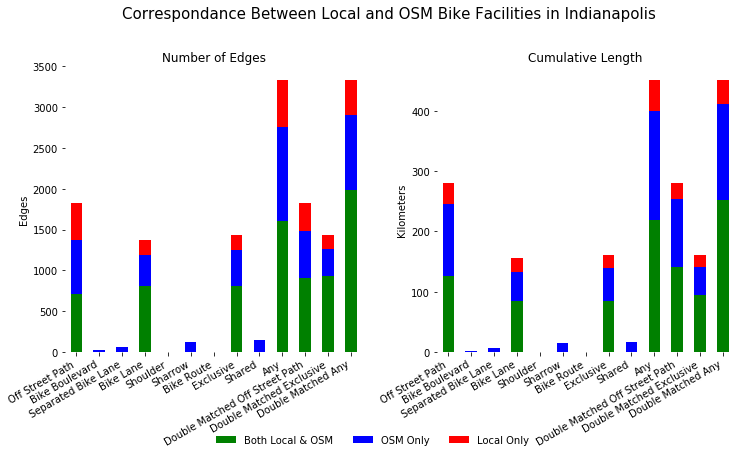

In [23]:
try:
    # Indianapolis
    def classify_indianapolis_lanes(row):
        if row['OPER_STATU'] == 'BUILT':
            return 'bike_lane'
        else:
            return np.nan

    def classify_indianapolis_trails(row):
        # All records are off street paths
        return 'off_street_path'

    indianapolis = City(
        name='Indianapolis',
        boundary_query='Marion County, Indiana, United States of America',
        local_bikeways=[
            {'file': 'bikeway_shapefiles/Indianapolis/IndianapolisBikeways.shp',
            'classification_function': classify_indianapolis_lanes,
            'name_column': 'STR_LABEL'},
            {'file': 'bikeway_shapefiles/Indianapolis/IndianapolisTrails.shp',
            'classification_function': classify_indianapolis_trails,
            'name_column': 'NAME'}],
        verbose=True
    )

    cities.append(indianapolis)
    indianapolis.plot_matches()
except:
    print("didn't work")

## Seattle

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Off Street Path'
Double Matching 'Exclusive'
Double Matching 'Shared'
Double Matching 'Any'


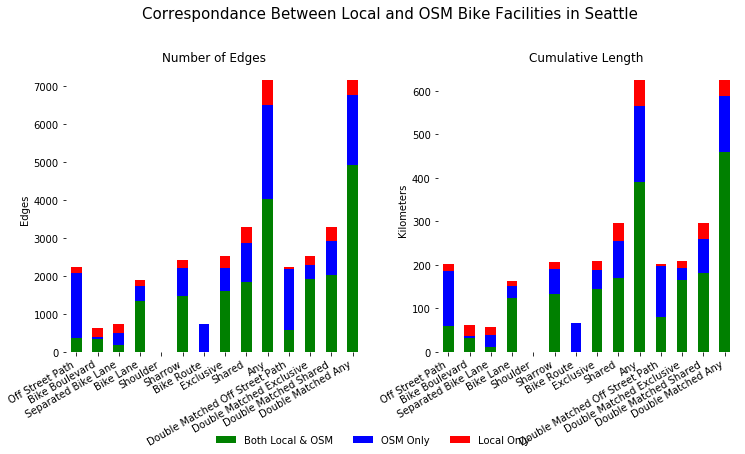

In [24]:
try:
    # Seattle
    def classify_seattle_bikeways(row):
        if row['existing_f'] == 'Multi-use Trail':
            return 'off_street_path'
        elif row['existing_f'] == 'Neighborhood Greenway':
            return 'bike_blvd'
        elif row['existing_f'] == 'In Street, Major Separation':
            return 'separated_bike_lane'
        elif row['existing_f'] == 'In Street, Minor Separation':
            return 'bike_lane'
        elif row['existing_f'] in ['Sharrow', 'sharrow', 'Sharow']:
            return 'sharrow'
        else:
            return np.nan

    seattle = City(
        name='Seattle',
        boundary_query='Seattle, King County, Washington, USA',
        local_bikeways={
            'file': 'bikeway_shapefiles/Seattle/SeattleBikeways.shp',
            'classification_function': classify_seattle_bikeways,
            'name_column': 'street_nam'},
        verbose=True
    )

    cities.append(seattle)
    seattle.plot_matches()
except:
    print("didn't work")

## Denver

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Off Street Path'
Double Matching 'Exclusive'
Double Matching 'Shared'
Double Matching 'Any'


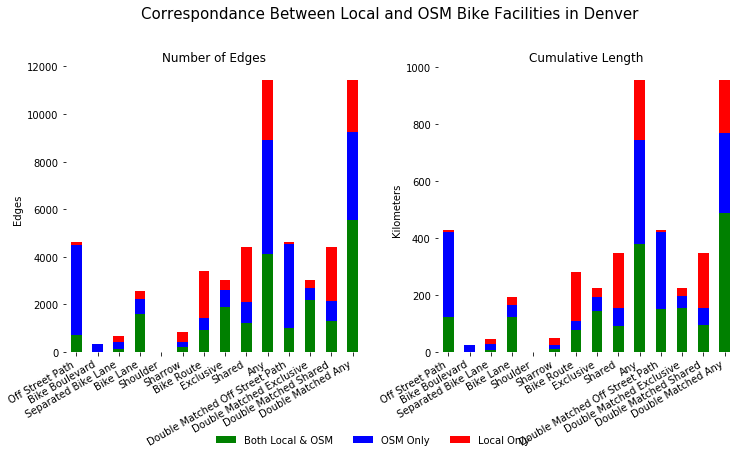

In [25]:
try:
    # Denver
    def classify_denver_bikeways(row):
        if row['EXISTING_F'] in [
            'RT', # Regional Trail
            'SUP', # Shared Use Path
            'MT', # Minor Trail
            'NT']: # Neighborhood Trail
            return 'off_street_path'
        elif row['EXISTING_F'] in [
            'BufBL', # Buffered Lane
            'CT']: # Cycle Track
            return 'separated_bike_lane'
        elif row['EXISTING_F'] in [
            'BL', # Bike Lane
            'CL', # Climbing Lane
            'PPBL']: # Shared Parking Bike Lane
            return 'bike_lane'
        elif row['EXISTING_F'] == 'PShdr': # Paved Shoulder
            return 'shoulder'
        elif row['EXISTING_F'] == 'SH': # Sharrow
            return 'sharrow'
        elif row['EXISTING_F'] == 'SRd': # Shared Roadway
            return 'bike_route'
        else:
            return np.nan

    denver = City(
        name='Denver',
        boundary_query='Denver, Denver County, Colorado, USA',
        local_bikeways={
            'file': 'bikeway_shapefiles/Denver/DenverBikeways.shp',
            'classification_function': classify_denver_bikeways,
            'name_column': 'FULLNAME'},
        verbose=True
    )

    cities.append(denver)
    denver.plot_matches()
except:
    print('failed')

## Washington

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Off Street Path'
Double Matching 'Exclusive'
Double Matching 'Shared'
Double Matching 'Any'


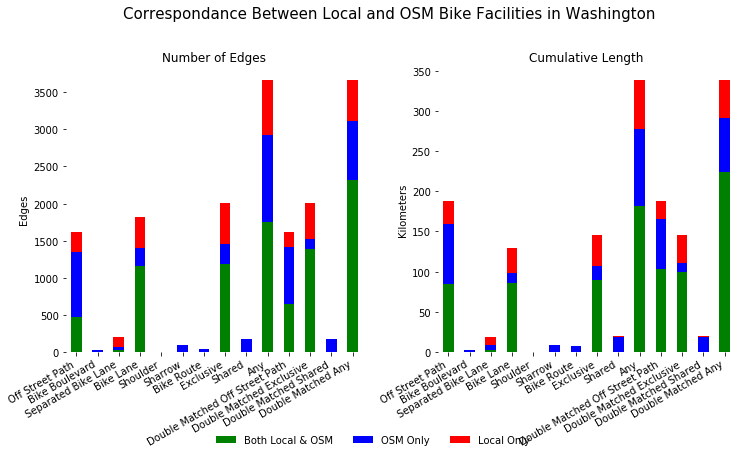

In [26]:
try:
    # Washington
    def classify_washington_bikeways(row):
        if row['FACILITY'] == 'Cycle Track':
            return 'separated_bike_lane'
        elif row['FACILITY'] in ['Existing Bike Lane', 'Climbing Lane', 'Contraflow Bike Lane']:
            return 'bike_lane'
        elif row['FACILITY'] == 'Bus/Bike Lane':
            return 'sharrow'
        else:
            return np.nan

    def classify_washington_trails(row):
        # All records are off street paths
        return 'off_street_path'

    washington = City(
        name='Washington',
        boundary_query='Washington, District of Columbia, USA',
        local_bikeways=[
            {'file': 'bikeway_shapefiles/Washington/Washington_BikeLanes.shp',
            'classification_function': classify_washington_bikeways,
            'name_column': 'FACILITYID'},
            {'file': 'bikeway_shapefiles/Washington/Washington_BikeTrails.shp',
            'classification_function': classify_washington_trails,
            'name_column': 'NAME'}],
        verbose=True
    )

    cities.append(washington)
    washington.plot_matches()
except:
    print('failed')

## El Paso

Matching Local and OSM Bikeways


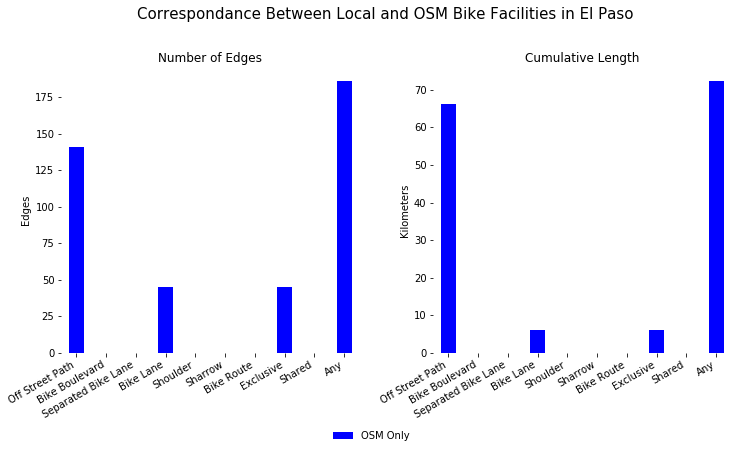

In [27]:
try:
    # El Paso
    # No open data source
    el_paso = City(
        name='El Paso',
        boundary_query='El Paso City, El Paso County, Texas, USA',
        verbose=True
    )

    cities.append(el_paso)
    el_paso.plot_matches()
except:
    print('failed')

## Boston

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Off Street Path'
Double Matching 'Exclusive'
Double Matching 'Shared'
Double Matching 'Any'


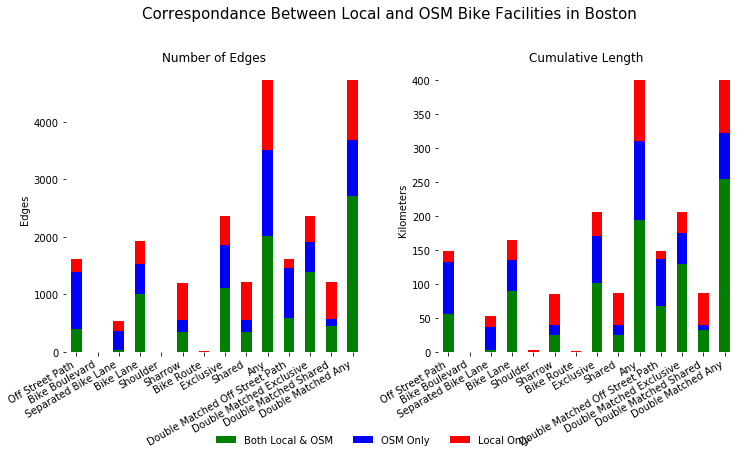

In [28]:
try:
    # Boston
    def classify_boston_bikeways(row):
        if row['ExisFacil'] in [
            'SUP', # Major Shared-Use Path
            'SUC', # Minor Shared-Use Path
            'SUB']: # Shared-Use Bridge
            return 'off_street_path'
        elif row['ExisFacil'] in [
            'BFBL', # Buffered Bike Lane
            'PBFBL', # ? Buffered Bike Lane
            'BFCL', # Buffered Climbing Lane
            'CTBL', # Cycle Track 1 direction, bike lane opposite direction
            'CT1', # Cycle Track, 1 side
            'CT2-1', # Cycle Track, 2 sides, One-Way
            'CT1-1', # Cycle Track, 1 sides, One-Way
            'CT1-2',]: # Cycle Track, 1 sides, Two-Way 
            return 'separated_bike_lane'
        elif row['ExisFacil'] in [
            'BL', # Bike Lane
            'CL', # Climbing Lane
            'CFBL']: # Contraflow Bike Lane
            return 'bike_lane'
        elif row['ExisFacil'] == 'PS': # Paved Shoulder
            return 'shoulder'
        elif row['ExisFacil'] in [
            'SLM', # Shared Lane Markings
            'BSBL', # Bus Bike Lane
            'PSL', # Priority Shared Lane Markings
            'SLM\r\n', # Shared Lane Markings ?
            'SLM\r\nSLM']: # Shared Lane Markings ?      
            return 'sharrow'
        elif row['ExisFacil'] == 'SRd': # Shared Road
            return 'bike_route'
        else:
            return np.nan

    boston = City(
        name='Boston',
        boundary_query='Boston, Suffolk County, Massachusetts, USA',
        local_bikeways={
            'file': 'bikeway_shapefiles/Boston/BostonBikeways.shp',
            'classification_function': classify_boston_bikeways,
            'name_column': 'STREET_NAM'},
        verbose=True
    )

    cities.append(boston)
    boston.plot_matches()
except:
    print('failed')

## Nashville

Matching Local and OSM Bikeways


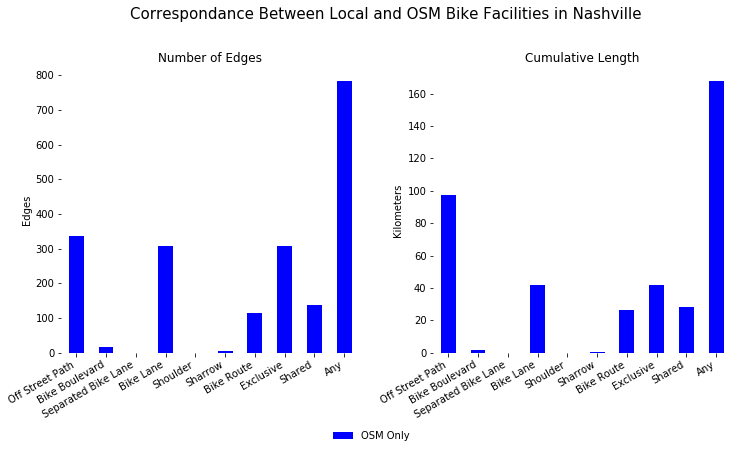

In [29]:
try:
    # Nashville
    nashville = City(
        name='Nashville',
        boundary_query='Nashville, Davidson County, Tennessee, USA',
        verbose=True
    )

    cities.append(nashville)
    nashville.plot_matches()
except:
    print('failed')

## Detroit

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Off Street Path'
Double Matching 'Exclusive'
Double Matching 'Shared'
Double Matching 'Any'


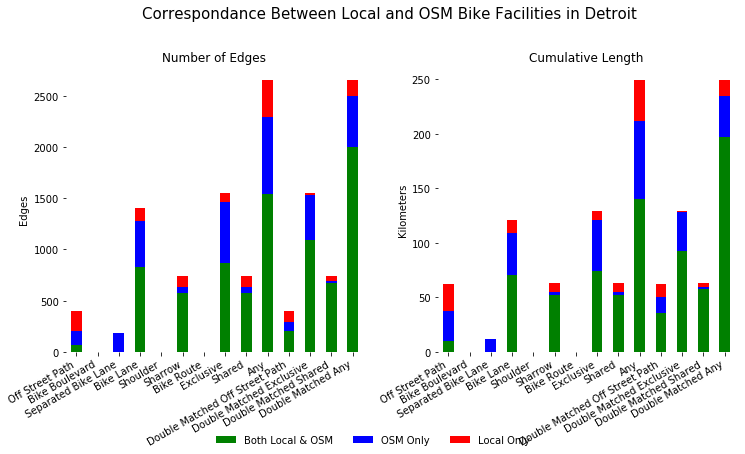

In [30]:
try:
    # Detroit
    def classify_detroit_bikeways(row):
        if (row['STATUS'] == 'COMPLETED' and
            row['TYPE'] in ['GREENWAY', 'INNER CIRCLE GREENWAY']):
            return 'off_street_path'
        elif (row['STATUS'] == 'COMPLETED' and
              row['TYPE'] == 'BIKE LANE'):
            return 'bike_lane'
        elif (row['STATUS'] == 'COMPLETED' and
              row['TYPE'] == 'SHARROW'):
            return 'sharrow'
        else:
            return np.nan

    def classify_detroit_trails(row):
        if row['status'] == 'Complete':
            return 'off_street_path'
        else:
            return np.nan

    detroit = City(
        name='Detroit',
        boundary_query='Detroit, Wayne County, Michigan, USA',
        local_bikeways=[
            {'file': 'bikeway_shapefiles/Detroit/DetroitBikeLanes.shp',
            'classification_function': classify_detroit_bikeways,
            'name_column': 'NAME'},
            {'file': 'bikeway_shapefiles/Detroit/DetroitGreenways.shp',
            'classification_function': classify_detroit_trails,
            'name_column': 'name'}],
        verbose=True
    )

    cities.append(detroit)
    detroit.plot_matches()
except:
    print('failed')

In [116]:
portland.summarize_matches(['any_bikeway','dbl_off_street_path','dbl_exclusive_bikeway'])

Any        Double Matched Off Street Path         \
                        Edges Length                          Edges Length   
OSM        Local                                                             
Bikeway    Bikeway     7231.0  662.6                         2582.0  240.6   
           No Bikeway  5797.0  548.5                         1151.0   91.5   
No Bikeway Bikeway     1362.0   68.5                         1007.0   50.0   
           No Bikeway     NaN    NaN                         9650.0  897.6   

                      Double Matched Exclusive         
                                         Edges Length  
OSM        Local                                       
Bikeway    Bikeway                      4045.0  344.3  
           No Bikeway                    326.0   31.5  
No Bikeway Bikeway                       194.0   11.1  
           No Bikeway                   9825.0  892.8

In [112]:
detroit.plot_comparison('any_bikeway', leaflet=True, plot_raw_local=True)

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19ea09b38>)

In [31]:
# detroit.save_results()

## Portland

Parsing Local Bikeways
Matching Local and OSM Bikeways
Double Matching 'Off Street Path'
Double Matching 'Exclusive'
Double Matching 'Shared'
Double Matching 'Any'


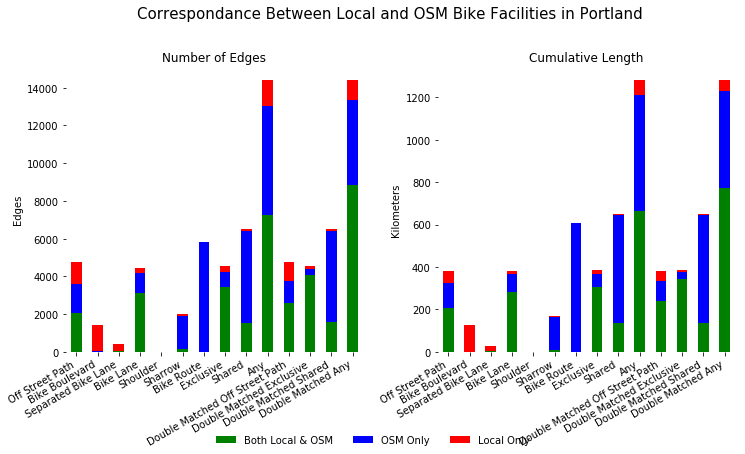

In [32]:
try:
    # Portland
    def classify_portland_bikeways(row):
        if row['BIKETYP'] in [
            'PTH-LOMU', # Local Multiuse Path
            'PTH-REMU', # Regional Multiuse Path
            'OTH-XING']: # Multiuse Overpass/Underpass
            return 'off_street_path'
        elif row['BIKETYP'] == 'BKE-BLVD': # Bike Blvd
            return 'bike_blvd'
        elif row['BIKETYP'] in [
            'BKE-BUFF', # Buffered Bike Lane
            'BKE-TRAK']: # Cycle Track
            return 'separated_bike_lane'
        elif row['BIKETYP'] == 'BKE-LANE': # Bike Lane
            return 'bike_lane'
        elif row['BIKETYP'] == 'SHL-WIDE': # Wide Shoulder
            return 'shoulder'
        elif row['BIKETYP'] in [
            'BKE-SHRD', # Shared Roadway or Marked Bicycle Route
            'OTH-CONN']: # Shared Roadway Gap Connector
            return 'sharrow'
        else:
            return np.nan

    portland = City(
        name='Portland',
        boundary_query='Portland, Multnomah County, Oregon, USA',
        boundary_number=0,    
        local_bikeways={
            'file': 'bikeway_shapefiles/Portland/MetroBikeways.shp',
            'classification_function': classify_portland_bikeways,
            'name_column': 'NAME'},
        verbose=True
    )

    cities.append(portland)
    portland.plot_matches()
except:
    print('failed')

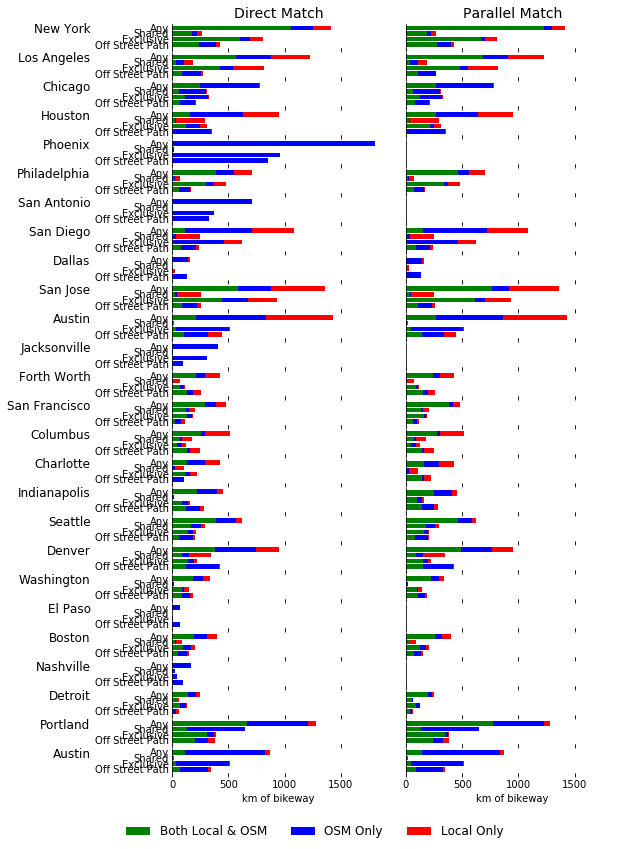

In [111]:
# Initialize figure with subplot axes
fig, ax = plt.subplots(ncols=2, nrows=len(cities), figsize=(8, (len(cities) * .5)), sharex=True)

# Remove space between subplots
# fig.tight_layout()

# Add column labels
for ax_, col in zip(ax[0], ['Direct Match', 'Parallel Match']):
    ax_.set_title(col, fontsize=14)

# Add row labels
for ax_, row in zip(ax[:,0], [city.name for city in cities]):
    ax_.set_ylabel(row, rotation=0, fontsize=12, horizontalalignment='right')

for i, city in enumerate(cities):
    # Specify colors and associated legend labels
    if hasattr(city, 'local_bikeways'):
        colors = ['g','b','r']
        labels = ['Both Local & OSM', 'OSM Only', 'Local Only']
    else:
        colors = ['b']
        labels = ['OSM Only']
               
    ## Direct Matches
    # Get summary table
    direct_match_summary = city.summarize_matches(
        ['any_bikeway', 'shared_bikeway', 'exclusive_bikeway', 'off_street_path'])
    # Remove summaries for neither OSM nor Local bikeways
    if ('No Bikeway','No Bikeway') in direct_match_summary.index:
        direct_match_summary = direct_match_summary.drop(
            [('No Bikeway','No Bikeway')])
    # Restrict to lengths
    direct_match_summary = direct_match_summary.xs('Length', level=1, axis=1)
    # Plot
    direct_match_summary.T.plot(
        kind='barh', stacked=True, color=colors, legend=False, ax=ax[i][0], width=0.8)
    # Add x axis label
    ax[i][0].set_xlabel('km of bikeway')
               
    ## Parallel Matches
    # Get summary table
    if any(['dbl' in x for x in city.matched_bikeways.columns]):
        parallel_match_summary = city.summarize_matches(
            ['dbl_any_bikeway', 'dbl_shared_bikeway', 'dbl_exclusive_bikeway', 'dbl_off_street_path'])
        # Remove summaries for neither OSM nor Local bikeways
        if ('No Bikeway','No Bikeway') in parallel_match_summary.index:
            parallel_match_summary = parallel_match_summary.drop(
                [('No Bikeway','No Bikeway')])
        # Restrict to lengths
        parallel_match_summary = parallel_match_summary.xs('Length', level=1, axis=1)
        # Plot
        parallel_match_summary.T.plot(
            kind='barh', stacked=True, color=colors, legend=False, ax=ax[i][1], width=0.8)
    # Remove y axis labels
    ax[i][1].set_yticklabels([])
    # Add x axis label
    ax[i][1].set_xlabel('km of bikeway')
        
# Modify all subplots
rows, columns = ax.shape
for i in range(rows):
    for j in range(columns):
        # Remove three sides of axis frames
        ax[i][j].spines['right'].set_visible(False)
        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].spines['bottom'].set_visible(False)
        # Remove y axis ticks
        ax[i][j].tick_params(axis='y',length=0)
        
# Make legend
fig.subplots_adjust(bottom=0.08)
handles, x = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=12).draw_frame(False)

plt.subplots_adjust(wspace=.1)

# Save as vector EPS
fig.savefig('test.eps', format='eps', dpi=1000)

In [110]:
new_york.summarize_lengths()

osm bikeway length: 1253 km
local bikeway length: 1236 km
local matched bikeway length: 1220 km
local & OSM bikeway length: 1058 km
dbl local & OSM bikeway length: 1223 km
local only bikeway length: 162 km
dbl local only bikeway length: 113 km
osm only bikeway length: 195 km
dbl osm only bikeway length: 79 km


In [34]:
for city in cities:
    city.matched_bikeways.to_pickle('results/{}_matched_bikeways.gdf'.format(city.name))

In [81]:
austin.plot_comparison(
    'any_bikeway', 
    leaflet=True, 
    plot_raw_local=True, 
#     plot_boundary=True
)



(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1370c6a58>)

In [108]:
# Export local bikeways
city = portland
city.local_bikeways.to_file('city_boundaries/{}_local_bikeways.shp'.format(city.name))

In [109]:
# Export city boundary
city = portland
gpd.GeoDataFrame(
    geometry=[ox.project_geometry(city.boundary, to_crs=city.crs)[0]],
    crs=city.crs).to_file('city_boundaries/{}_boundary.shp'.format(city.name))

In [94]:
# Export clipped Bikeway boundary
clipped_local_bikeways.to_file('city_boundaries/austin_clipped.shp')

In [70]:

sum([x.length for x in san_francisco.local_bikeways['geometry'].tolist()])

719855.798700661

In [88]:
# Clip local bikeways to city boundary
city = austin
clipped_local_bikeways = sp.gdf_clip_line_by_polygon(
    city.local_bikeways,
    gpd.GeoDataFrame(
        geometry=[ox.project_geometry(city.boundary, to_crs=city.crs)[0]],
        crs=city.crs))
sum([x.length for x in clipped_local_bikeways['geometry'].tolist()])/1000

180.30817161655227

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14d8d1cc0>)

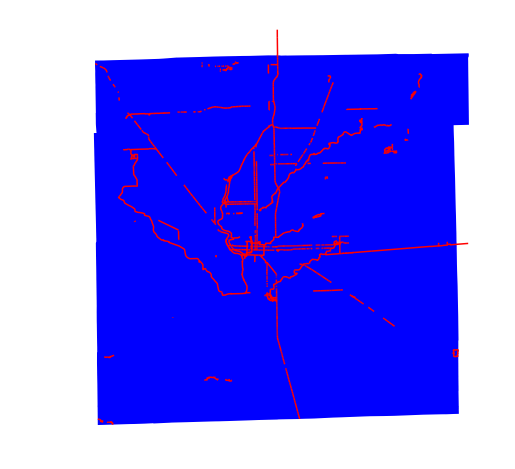

In [103]:
# Plot local bikeways, matched bikeways, and city boundary
city = indianapolis
sp.plot_shapes([
#     (city.matched_bikeways, {'color':'g'}),
#     (clipped_local_bikeways, {'color':'k'}),
    (city.local_bikeways, {'color':'r'}),
    
    ox.project_geometry(city.boundary, to_crs=city.crs)[0],
    ], 
#     leaflet=True
)



## Oklahoma City

## Las Vegas

## Memphis

## Louisville

## Baltimore

## Milwaukee

## Albuquerque

## Tucson

## Fresno

## Sacramento

## Mesa

## Kansas City

## Atlanta

## Colorado Springs

## Miami

## Raleigh

## Long Beach

## Virginia Beach

## Omaha

## Oakland

## Minneapolis

## Tulsa

## Arlington

## New Orleans

## Tampa

### Portland, Oregon

In [ ]:
# Download boundary polygon
def download_portland_boundary():
    # Download OSM boundary
    boundary = ox.gdf_from_place(
        'Portland, Oregon, United States')
    # Extract geometry
    boundary = boundary.at[0,'geometry']
    return boundary

# Classify bikeways in Portland Shapefile
def classify_portland_bikeways(row):
    if row['BIKETYP'] in ['PTH-LOMU', 'PTH-REMU', 'OTH-XING']:
        return 'off_street_path'
    elif row['BIKETYP'] in ['BKE-BLVD']:
        return 'bike_blvd'
    elif row['BIKETYP'] in ['BKE-BUFF', 'BKE-TRAK']:
        return 'separated_bike_lane'
    elif row['BIKETYP'] in ['BKE-LANE']:
        return 'bike_lane'
    elif row['BIKETYP'] in ['SHL-WIDE']:
        return 'shoulder'
    elif row['BIKETYP'] in ['BKE-SHRD', 'OTH-CONN']:
        return 'sharrow'
    else:
        return np.nan

# Compare OSM and Local Bikeways
# compare_osm_and_local_bikeways.clear() # Uncomment to clear cache and force recompute
portland_summaries, portland_matches = compare_osm_and_local_bikeways(
    city='Portland',
    boundary=download_portland_boundary(), 
    crs={'init': 'epsg:26910'}, # UTM 10N
    local_edges=compare_bikeways.structure_bikeways_shapefile(
        shp_path='bikeway_shapefiles/Portland/bike_routes.shp',
        classification_function=classify_portland_bikeways,
        name_column='NAME'))

# Plot results
compare_bikeways.plot_local_osm_comparison(portland_summaries, 'Portland')

### San Francisco, California

In [ ]:
# Download boundary polygon
def download_sf_boundary():
    # Download OSM boundary
    boundary = ox.gdf_from_place(
        'San Francisco City and County, California, United States of America')
    # Extract geometry
    boundary = boundary.at[0,'geometry']
    # Select second of two polygons in multipolygon
    boundary = [x for x in boundary][1]
    return boundary

# Classify bikeways in San Francisco Shapefile
def classify_sf_bikeways(row):
    if row['facility_t'] == 'CLASS I':
        return 'off_street_path'
    elif row['symbology'] == 'NEIGHBORWAY':
        return 'bike_blvd'
    elif ((row['facility_t'] == 'CLASS IV') or 
          (row['buffered'] == 'YES') or
          (pd.notnull(row['barrier'])) or
          (row['raised'] == 'YES')):
        return 'separated_bike_lane'
    elif row['facility_t'] == 'CLASS II':
        return 'bike_lane'
    elif row['sharrow'] > 0:
        return 'sharrow'
    elif row['symbology'] == 'BIKE ROUTE':
        return 'bike_route'
    else:
        return np.nan

# Compare OSM and Local Bikeways
# compare_osm_and_local_bikeways.clear() # Uncomment to clear cache and force recompute
sf_summaries, sf_matches = compare_osm_and_local_bikeways(
    city='San Francisco',
    boundary=download_sf_boundary(), 
    crs={'init': 'epsg:26910'}, # UTM 10N  
    local_edges=compare_bikeways.structure_bikeways_shapefile(
        shp_path='bikeway_shapefiles/San_Francisco/SanFranciscoBikeways.shp',
        classification_function=classify_sf_bikeways,
        name_column='street'))

# Plot results
compare_bikeways.plot_local_osm_comparison(sf_summaries, 'San Francisco')

### New York, New York

In [ ]:
# Download boundary polygon
def download_nyc_boundary():
    # Download OSM boundary
    boundary = ox.gdf_from_place(
        'New York City, New York, United States of America')
    # Extract geometry
    boundary = boundary.at[0,'geometry']
    # Select second of two polygons in multipolygon
    boundary = [x for x in boundary][0]
    return boundary

# Classify bikeways in  New York Shapefile
def classify_nyc_bikeways(row):
    # See if any bikeway field contains a certain bikeway
    def any_bikeway(bikeway):
        bikeway_fields = [row['ft_facilit'], row['tf_facilit']]
        return any([bikeway in x if x is not None else False 
                    for x in bikeway_fields])   
    # Test for bikeway types in descending order
    if(
        any_bikeway('Greenway') or
        any_bikeway('Boardwalk') or
        any_bikeway('Ped Plaza') or
        any_bikeway('Dirt Trail')):
        return 'off_street_path'
    elif(
        any_bikeway('Buffered Conventional') or
        any_bikeway('Protected Path')):
        return 'separated_bike_lane'
    elif( 
        any_bikeway('Bike-Friendly Parking') or
        any_bikeway('Curbside') or
        any_bikeway('Standard')):
        return 'bike_lane'
    elif(
        any_bikeway('Sharrow')):
        return 'sharrow'
    elif(
        any_bikeway('Signed Route')):
        return 'bike_route'
    else:
        return np.nan

# Compare OSM and Local Bikeways
# compare_osm_and_local_bikeways.clear() # Uncomment to clear cache and force recompute
nyc_summaries, nyc_matches = compare_osm_and_local_bikeways(
    city='New York',
    boundary=download_nyc_boundary(), 
    crs={'init': 'epsg:26918'}, # UTM 18N 
    local_edges=compare_bikeways.structure_bikeways_shapefile(
        shp_path='bikeway_shapefiles/New_York/NewYorkBikeways.shp',
        classification_function=classify_nyc_bikeways,
        name_column='street'))

# Plot results
compare_bikeways.plot_local_osm_comparison(nyc_summaries, 'New York')